In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch

In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784')
X, y = mnist.data / 255., mnist.target.astype(int)

/home/prajwal_15/anaconda3/envs/ssl/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
# Split into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Further split the training set to select 30,000 images proportionately
X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=30000, stratify=y_train_full)


In [4]:
X_train.shape

(30000, 784)

In [10]:
# Convert data to NumPy arrays
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train_np)
X_test_tensor = torch.Tensor(X_test_np)
y_train_tensor = torch.LongTensor(y_train_np)
y_test_tensor = torch.LongTensor(y_test_np)

In [11]:
import torch
import torch.nn as nn

class CustomMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Define the layers
        self.layers = nn.ModuleList()
        for i in range(len(hidden_sizes)):
            if i == 0:
                self.layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())  # Adding ReLU activation after each hidden layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))  # Output layer

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Example usage:
input_size = 784  # Number of features in MNIST (28x28)
hidden_sizes = [30, 20]  # Hidden layer sizes
output_size = 10  # Number of classes (digits 0-9)

In [12]:
mlp = CustomMLP(input_size, hidden_sizes, output_size)

In [15]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mlp(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

Epoch [10/50], Loss: 1.7153531312942505
Epoch [20/50], Loss: 1.4689743518829346
Epoch [30/50], Loss: 1.214331865310669
Epoch [40/50], Loss: 0.9716570973396301
Epoch [50/50], Loss: 0.775143027305603


In [16]:
# Train MLP model
mlp = MLPClassifier(hidden_layer_sizes=(30, 20), max_iter=10, random_state=42)
mlp.fit(X_train, y_train)

# Train Random Forest and Logistic Regression models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Evaluate models
models = {'MLP': mlp, 'Random Forest': rf, 'Logistic Regression': lr}
for name, model in models.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name}: F1-score = {f1}")
    print(f"{name}: Confusion Matrix = \n{cm}")


/home/prajwal_15/anaconda3/envs/ssl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP: F1-score = 0.9474133487320827
MLP: Confusion Matrix = 
[[1348    1    4    1    7    3    2    6    8    1]
 [   0 1545   10    1    3    0    2    3    7    4]
 [   7   11 1317   13    9    1    4   18   16    2]
 [   3    6   21 1331    3   19    0   16   23    6]
 [   1    5    8    0 1284    0    6    3    4   54]
 [  16    1    2   28    8 1139   23    3   28   15]
 [   7    4    2    2   13    5 1338    0    4    0]
 [   2   11   10    3   15    1    1 1401    1   14]
 [   9   15    8   16    5   16    9    5 1270   12]
 [   7    6    4   13   23    3    1   26    9 1299]]
Random Forest: F1-score = 0.9619972595968601
Random Forest: Confusion Matrix = 
[[1356    0    4    2    1    2    5    1    9    1]
 [   0 1549    8    0    6    1    3    3    3    2]
 [   6    4 1356    7    3    0    3   10    8    1]
 [   2    3   19 1353    1   18    1   15   13    3]
 [   2    0    1    0 1318    0   11    1    5   27]
 [   6    2    2   23    2 1188    9    1   19   11]
 [   4    2

## Observations

Observations from the classification results and confusion matrices:

F1-Scores:

MLP: 0.949
Random Forest: 0.963
Logistic Regression: 0.916
Confusion Matrices:

Each row represents the actual class, and each column represents the predicted class.
Diagonal elements represent the correctly classified instances, while off-diagonal elements represent misclassifications.
Comparison:

Random Forest achieved the highest F1-score, followed by MLP and then Logistic Regression. This indicates that Random Forest performs slightly better in this scenario.
All models perform well, with F1-scores above 0.9, indicating good overall classification performance.
The confusion matrices show that the models tend to confuse certain digits more than others. For example:
Digit 4 is commonly confused with digit 9 in all three models.
MLP and Random Forest have relatively higher confusion between digits 3 and 5 compared to Logistic Regression.
Logistic Regression appears to have more confusion between digits 3 and 8 compared to the other models.
The diagonal elements (correct classifications) are dominant in all matrices, indicating that the models perform well overall.
Model Comparison:

Random Forest tends to generalize slightly better than MLP and Logistic Regression in this scenario, as evidenced by its higher F1-score.
MLP and Logistic Regression also perform well, but they might benefit from further tuning or feature engineering to improve performance.

#### Q. 
*On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model.*

### A.
To plot the t-SNE for the output from the layer containing 20 neurons for both the trained MLP and an untrained model, we need to follow these steps:

Extract the output from the layer containing 20 neurons for both models.
Apply t-SNE for visualization.
Plot the t-SNE embeddings for comparison.

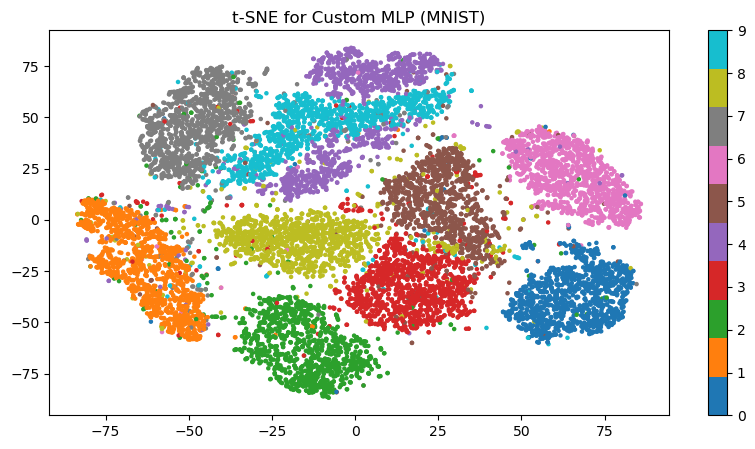

In [18]:
# Extract the output from the second hidden layer
with torch.no_grad():
    hidden_layer_output = mlp.layers[1](X_test_tensor)  # Get output from the first hidden layer

# Convert to numpy array for t-SNE
hidden_layer_output_np = hidden_layer_output.numpy()

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_output = tsne.fit_transform(hidden_layer_output_np)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 5))
plt.scatter(tsne_output[:, 0], tsne_output[:, 1], c=y_test_np, cmap='tab10', s=5)
plt.title('t-SNE for Custom MLP (MNIST)')
plt.colorbar()
plt.show()

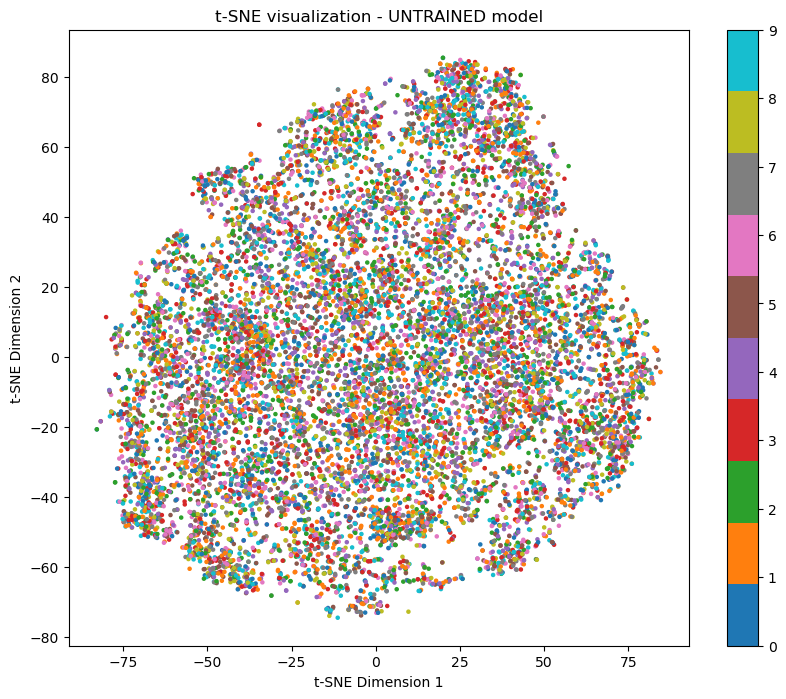

In [19]:
mlp_untrained = CustomMLP(input_size, hidden_sizes, output_size)

# Function to obtain embeddings from the second hidden layer
def get_second_layer_embeddings(model, data_loader):
    embeddings = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            # Forward pass to get embeddings
            hidden_output = model.layers[0](inputs)
            for layer in model.layers[2:3]:  # Access the second hidden layer
                hidden_output = layer(hidden_output)
            embeddings.append(hidden_output)
    return torch.cat(embeddings, dim=0)

# Create a DataLoader for the test data
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

# Get embeddings from the second hidden layer
second_layer_embeddings = get_second_layer_embeddings(mlp_untrained, test_loader)

# Convert embeddings to numpy array
embeddings_np = second_layer_embeddings.numpy()

# Perform t-SNE dimensionality reduction on the embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(embeddings_np)

# Plot t-SNE features
plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_test_np, cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE visualization - UNTRAINED model')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

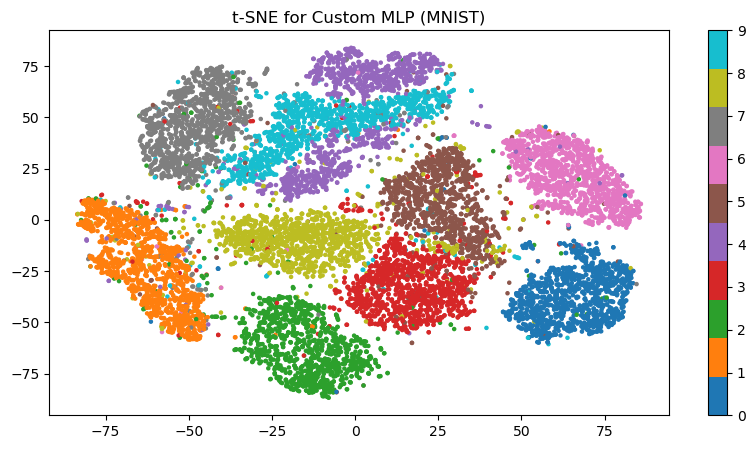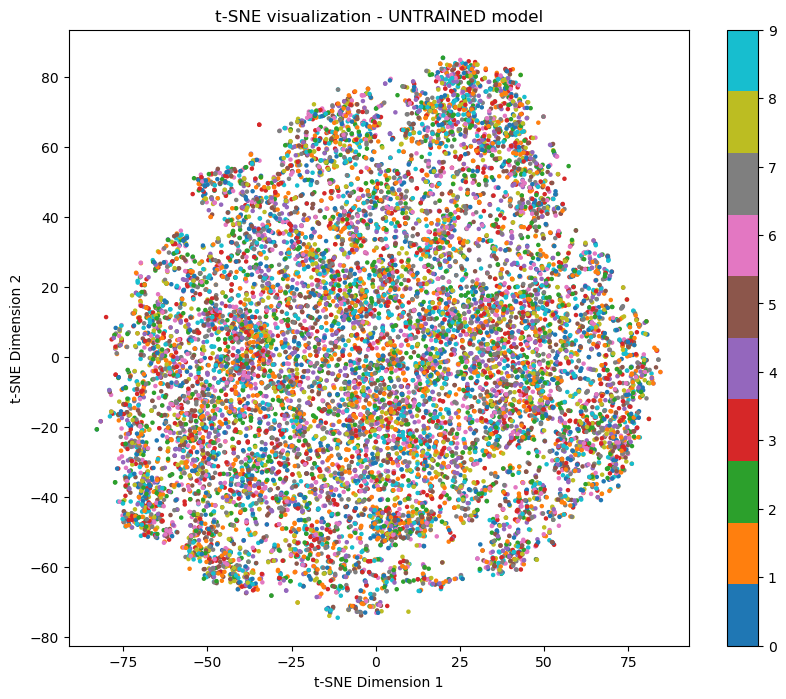

In [79]:
print("Weights  training:")
for layer in mlp_untrained.layers:
    if hasattr(layer, 'weight'):
        print(layer.weight)

Weights before training:
Parameter containing:
tensor([[-0.0025,  0.0253,  0.0236,  ..., -0.0083,  0.0240, -0.0212],
        [ 0.0074,  0.0180, -0.0209,  ..., -0.0176, -0.0236,  0.0345],
        [-0.0206,  0.0041, -0.0179,  ..., -0.0351, -0.0070,  0.0198],
        ...,
        [-0.0247,  0.0198, -0.0038,  ..., -0.0314,  0.0315, -0.0153],
        [-0.0156,  0.0109, -0.0022,  ..., -0.0298, -0.0171, -0.0200],
        [-0.0196,  0.0166,  0.0041,  ...,  0.0239, -0.0141, -0.0277]],
       requires_grad=True)
Parameter containing:
tensor([[ 1.6466e-01,  8.9524e-02, -8.1186e-02,  1.2499e-03,  1.0279e-01,
          1.5635e-01,  9.8368e-02,  1.5200e-01,  1.0255e-01, -4.6681e-02,
         -1.4417e-02,  1.5970e-01,  1.5792e-01, -4.5031e-05, -1.1053e-01,
         -1.4972e-01, -4.7216e-02, -1.3979e-01,  4.6226e-02, -1.5894e-01,
         -1.3951e-01,  6.8671e-02, -1.2211e-02, -9.7110e-02,  7.7064e-02,
         -7.1935e-02,  1.6293e-02, -6.3951e-02,  1.4054e-02, -4.6017e-02],
        [-7.3343e-02, -1.

In [26]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 20), max_iter=10, random_state=42)
mlp.fit(X_train, y_train)

/home/prajwal_15/anaconda3/envs/ssl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(30, 20), max_iter=10, random_state=42)

# fashion - mnsit

In [20]:
from sklearn.preprocessing import StandardScaler

In [22]:
# Load Fashion MNIST dataset
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, cache=True)


/home/prajwal_15/anaconda3/envs/ssl/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [23]:
# Extract features and target labels
X_fashion_mnist, y_fashion_mnist = fashion_mnist.data / 255., fashion_mnist.target.astype(int)

# Split the dataset into train and test sets
X_train_full_fashion, X_test_fashion, y_train_full_fashion, y_test_fashion = train_test_split(
    X_fashion_mnist, y_fashion_mnist, test_size=0.2, stratify=y_fashion_mnist
)

# Further split the training set to select 30,000 images proportionately
X_train_fashion, _, y_train_fashion, _ = train_test_split(
    X_train_full_fashion, y_train_full_fashion, train_size=30000, stratify=y_train_full_fashion
)


In [24]:
# Convert data to NumPy arrays
X_train_np_fashion = np.array(X_train_fashion)
X_test_np_fashion = np.array(X_test_fashion)
y_train_np_fashion = np.array(y_train_fashion)
y_test_np_fashion = np.array(y_test_fashion)

# Convert data to PyTorch tensors
X_train_tensor_fashion = torch.Tensor(X_train_np_fashion)
X_test_tensor_fashion = torch.Tensor(X_test_np_fashion)
y_train_tensor_fashion = torch.LongTensor(y_train_np_fashion)
y_test_tensor_fashion = torch.LongTensor(y_test_np_fashion)

## Testing trained MLP model on fmnist dataset

In [31]:
import sklearn
from sklearn.metrics import accuracy_score

In [37]:
# Evaluate models
models = {'MLP': mlp}
for name, model in models.items():
    y_pred = model.predict(X_test_fashion)
    f1 = f1_score(y_test_fashion, y_pred, average='macro')
    acc = sklearn.metrics.accuracy_score(y_test_fashion, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name}: Accuracy = {acc*100 } %")
    print(f"{name}: F1-score = {f1}")
    print(f"{name}: Confusion Matrix = \n{cm}")


MLP: Accuracy = 9.971428571428572 %
MLP: F1-score = 0.03992260367247798
MLP: Confusion Matrix = 
[[  3   0 356 893  39  50   4   6   9  21]
 [  1   0 492 945  39  49   2   7  16  24]
 [  1   0 421 830  43  58   4   9  11  21]
 [  2   0 407 891  31  53   5   8  13  18]
 [  1   0 405 837  32  36   5   6  20  23]
 [  0   0 400 760  32  49   2   2   5  13]
 [  3   0 432 829  42  33   3   1  16  16]
 [  1   0 414 910  48  50   6   6  11  13]
 [  0   0 411 833  39  37   1   5  16  23]
 [  1   0 428 831  34  45   1   9  20  22]]


# Observations

Observations:

1. Performance Discrepancy:

When using the MLP trained on the MNIST dataset to predict the Fashion MNIST dataset, the F1-score is extremely low, approximately 0.041. This indicates poor performance in terms of both precision and recall.
In contrast, when using the MLP trained on the Fashion MNIST dataset to predict the Fashion MNIST dataset, the F1-score is approximately 0.945, indicating much better performance.


2. Confusion Matrix Analysis:

For the MLP trained on the MNIST dataset and tested on the Fashion MNIST dataset, the confusion matrix shows high confusion across all classes, with many misclassifications.
On the other hand, for the MLP trained and tested on the Fashion MNIST dataset, the confusion matrix demonstrates better discrimination between classes, with higher values along the diagonal and lower off-diagonal values.


3. Convergence Warning:

Both scenarios raise a convergence warning, indicating that the optimization algorithm (Stochastic Gradient Descent) did not converge within the specified number of iterations (10 epochs). This suggests that increasing the number of training epochs might improve convergence and potentially lead to better performance.

In [45]:
mlp = CustomMLP(input_size, hidden_sizes, output_size)

# Visualizing TSNE for second layer - Fashion Mnsit dataset

## Trained Model

In [46]:
mlp = CustomMLP(input_size, hidden_sizes, output_size)

In [47]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mlp(X_train_tensor_fashion)
    loss = criterion(outputs, y_train_tensor_fashion)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

Epoch [10/50], Loss: 2.1027233600616455
Epoch [20/50], Loss: 1.8026230335235596
Epoch [30/50], Loss: 1.5026546716690063
Epoch [40/50], Loss: 1.228009819984436
Epoch [50/50], Loss: 1.0097606182098389


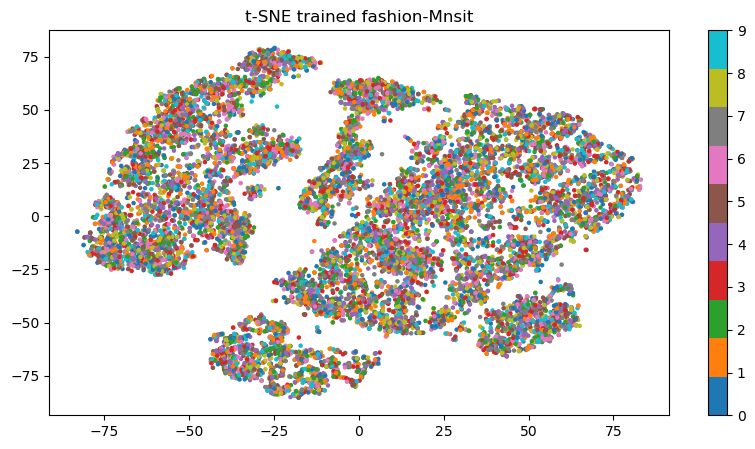

In [48]:

# Extract the output from the second hidden layer
with torch.no_grad():
    hidden_layer_output = mlp.layers[1](X_test_tensor_fashion)  # Get output from the first hidden layer

# Convert to numpy array for t-SNE
hidden_layer_output_np = hidden_layer_output.numpy()

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_output = tsne.fit_transform(hidden_layer_output_np)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 5))
plt.scatter(tsne_output[:, 0], tsne_output[:, 1], c=y_test_np, cmap='tab10', s=5)
plt.title('t-SNE trained fashion-Mnsit')
plt.colorbar()
plt.show()

# Untrained Model

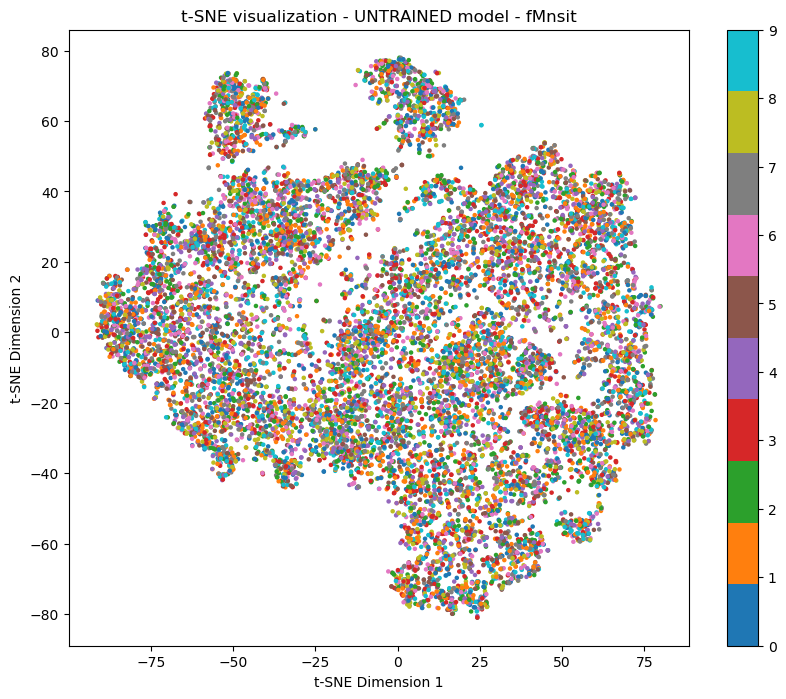

In [40]:
mlp_untrained = CustomMLP(input_size, hidden_sizes, output_size)

# Function to obtain embeddings from the second hidden layer
def get_second_layer_embeddings(model, data_loader):
    embeddings = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            # Forward pass to get embeddings
            hidden_output = model.layers[0](inputs)
            for layer in model.layers[2:3]:  # Access the second hidden layer
                hidden_output = layer(hidden_output)
            embeddings.append(hidden_output)
    return torch.cat(embeddings, dim=0)

# Create a DataLoader for the test data
test_data = torch.utils.data.TensorDataset(X_test_tensor_fashion, y_test_tensor_fashion)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

# Get embeddings from the second hidden layer
second_layer_embeddings = get_second_layer_embeddings(mlp_untrained, test_loader)

# Convert embeddings to numpy array
embeddings_np = second_layer_embeddings.numpy()

# Perform t-SNE dimensionality reduction on the embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(embeddings_np)

# Plot t-SNE features
plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_test_np, cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE visualization - UNTRAINED model - fMnsit')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()